In [1]:
import matplotlib.pyplot as plt

import numpy as np
from scipy.signal import decimate

import emd

from neurodsp.utils.norm import normalize_sig
from neurodsp.filt import filter_signal
from neurodsp.spectral import compute_spectrum

from timescales.sim import sim_branching, sim_asine_oscillation, sim_autoregressive
from timescales.fit import convert_knee_val
from timescales.decompose import CAD, CADGroup, asym_osc_decomposition, ar_psd

### Autoregressive Decomposition
This notebook uses a modified version of "canonical autoregressive decomposition" (CAD) decribed in (Nagesha & Kay, 1994). CAD involves modeling sinusoids separately from AR coefficients. The modification include here adds a parameter allowing non-sinusoidality in the oscillatory term.

The second half of this notebook introduces an iterative process to automatically estimate the periodic model.

#### Aperiodic: AR(p) Model
$$A_{n} = \sum_{k=1}^{p}a_{k} X_{n-k} + \varepsilon_{n}$$

#### Periodic: Non-Sinusoidal Oscillatory Model

$$w_{i} = e^{j \phi_{i}} e^{j 2\pi f_{i} n}$$

$$z_{i} = w_{i} \cdot e^{j c_{i} w+{i}}$$

$$P_{n} = \sum_{i=1}^{s}z_{i}$$

#### Full Model

$$x_{n} = \sum_{i=1}^{s}z_{i} + \sum_{i=1}^{p}a_{k} X_{n-k} + \varepsilon_{n}$$

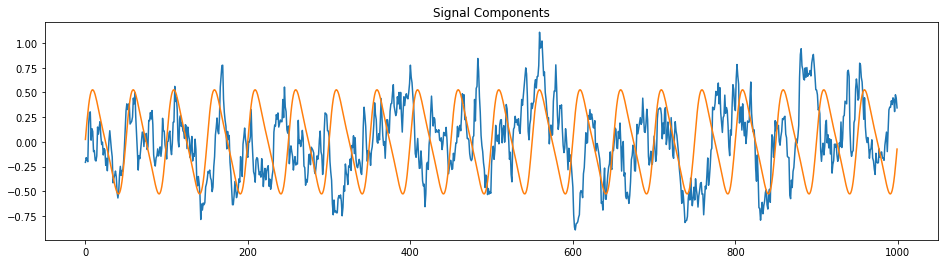

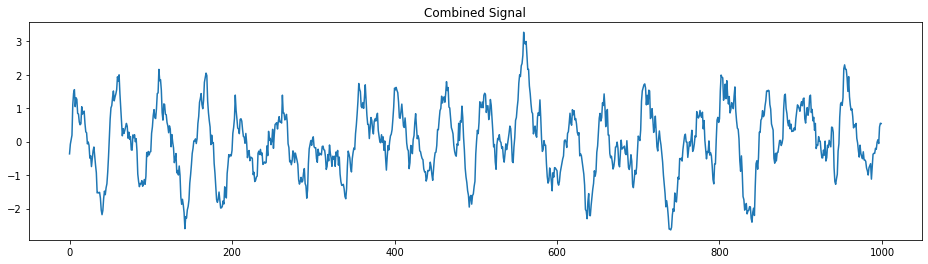

In [2]:
# Simulate
np.random.seed(0)

n_seconds = 1
fs = 1000
tau = convert_knee_val(10)
xs = np.arange(fs)

lfp = sim_branching(n_seconds, fs, tau, 100)
osc = sim_asine_oscillation(xs, fs, 20, .25, -.49, 1)

osc_var = .5
lfp = normalize_sig(lfp, 0, (1-osc_var)) 
osc = normalize_sig(osc, 0, (osc_var)) 

sig = lfp + osc

plt.figure(0, figsize=(16, 4))
plt.title('Signal Components')
plt.plot(lfp/2)
plt.plot(osc/2)

plt.figure(1, figsize=(16, 4))
plt.title('Combined Signal')
plt.plot(sig);


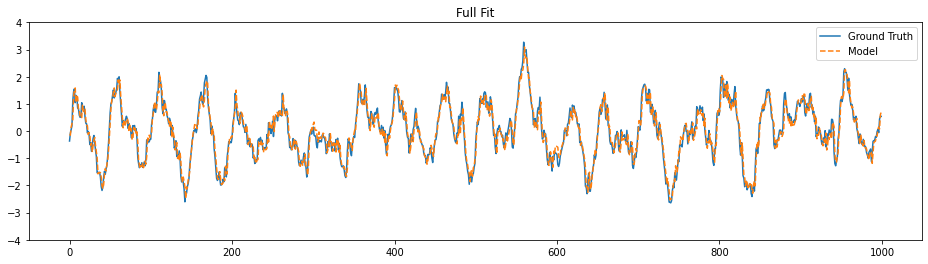

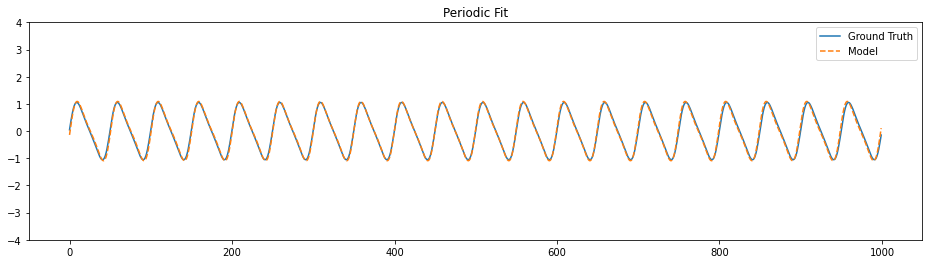

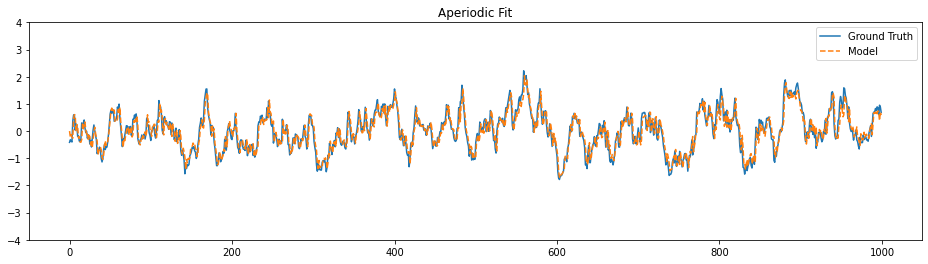

In [3]:
# Fit
osc_order = 1
ar_order = 2

cad = CAD(sig, fs, osc_order, ar_order)
cad.fit()

# Plot Results
plt.figure(0, figsize=(16, 4))
plt.title('Full Fit')
plt.plot(sig, label='Ground Truth')
plt.plot(cad.full_fit, ls='--', label='Model')
plt.ylim(-4, 4)
plt.legend();

plt.figure(1, figsize=(16, 4))
plt.title('Periodic Fit')
plt.plot(osc, label='Ground Truth')
plt.plot(cad.osc_fit, ls='--', label='Model')
plt.ylim(-4, 4)
plt.legend();

plt.figure(2, figsize=(16, 4))
plt.title('Aperiodic Fit')
plt.plot(lfp, label='Ground Truth')
plt.plot(cad.ar_fit, ls='--', label='Model')
plt.ylim(-4, 4)
plt.legend();

# Asymmetrical Mode Decomposition

Complex waveform shapes may be fit using an iterative process in which asymmetrical waves are fit to a signal in ascending (or descending) frequency order. This method allows periodic and aperiodic components to be separated in the time domain, and timescale to be more accurately quantified using autoregressive PSD.

This process involves optimizing the oscillatory term in the CAD equation using tiny asine oscillators.

1. Define a frequency range to step through (i.e. np.arange(100))
2. For each frequency in the range: 
   <br> a. optimize the best non-sinusoidal wave that fits the signal
   <br> b. if the r-squared of the fit is above threshold, accept the mode
   <br> c. subtract accepted modes from the signal and continue

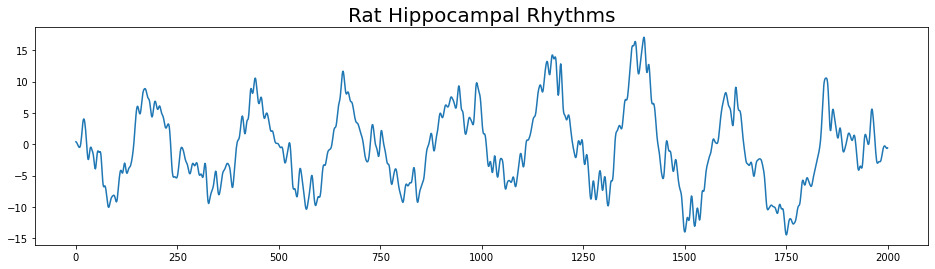

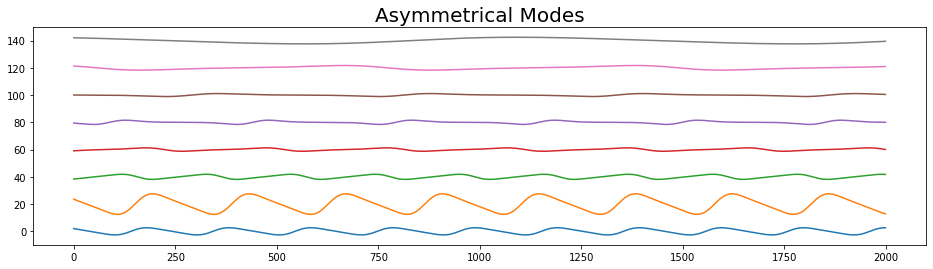

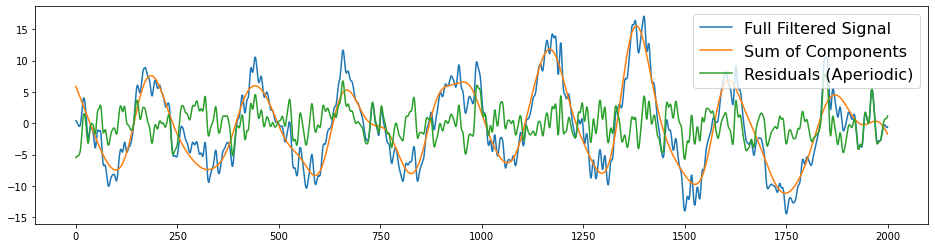

In [4]:
# Load data
file_path_dat = "/home/rph/Projects/bycycle/sim_nbs/crcns/hc2/ec013.527/ec013.527.dat"
num_channels = 31
fs = 20000

with open(file_path_dat, mode='rb') as file: 
    file_content = file.read()
    
sig = np.frombuffer(file_content, dtype=np.short)
sig = np.reshape(sig, (-1, num_channels)).T

sig = sig[20] / 100

# Slice and downsample
i = 100000
j = i+20000

sig_down = decimate(sig[i:j], 10)
sig_down = filter_signal(sig_down, fs/10, 'lowpass', 200, remove_edges=False)

# Fit
_sig = sig_down.copy()
freqs = np.logspace(np.log(1), np.log(10), 100)[::-1]
sig_osc_fit, params = asym_osc_decomposition(_sig, fs/10, freqs, .2, 2)
sig_pe = sig_osc_fit.sum(axis=0)
sig_ap = _sig - sig_pe

# Plot
plt.figure(1, figsize=(16, 4))
plt.plot(sig_down)
plt.title('Rat Hippocampal Rhythms', size=20)

plt.figure(2, figsize=(16, 4))
plt.title('Asymmetrical Modes', size=20)
j = 0
for i in sig_osc_fit:
    plt.plot(i + j)
    j += 20
    
plt.figure(3, figsize=(16, 4))
plt.plot(sig_down, label='Full Filtered Signal')
plt.plot(sig_pe, label='Sum of Components')
plt.plot(sig_ap, label='Residuals (Aperiodic)')
plt.legend(fontsize=16);

### Improved Asymmetrical Fitting
To improve the fit, we can lower the r-squared threshold and step through more frequencies. The resulting modes can be binned to reduce the large number.

In [5]:
# Fit
sig = sig_down.copy()
sig = sig - sig.mean()
freqs = np.linspace(0, 200, 401)

bounds = [
    [-1, -1, 0],
    [ 1,  1, 10]
]

guess = [0, 0, 1]

sig_osc_fit, params = asym_osc_decomposition(sig, fs/10, freqs, 0.05, 1,
                                             guess=guess, bounds=bounds)

# EMD for comparison
x = emd.sift.sift(sig_down, max_imfs=5)
x = x.T[::-1]

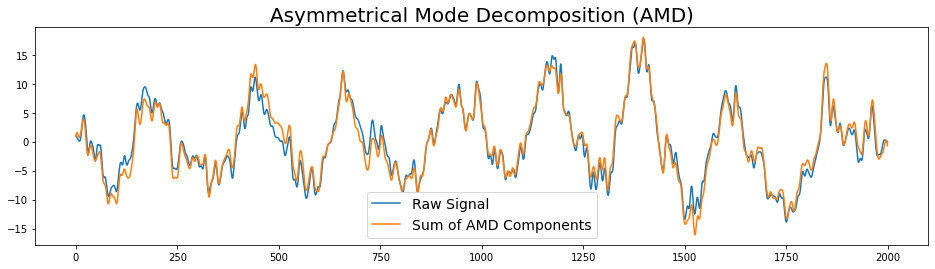

In [6]:
# Plot full fit
plt.figure(0, figsize=(16, 4))
plt.plot(sig, label='Raw Signal')
plt.plot(sig_osc_fit.sum(axis=0), label='Sum of AMD Components')
plt.title('Asymmetrical Mode Decomposition', size=20)
plt.legend(fontsize=14);

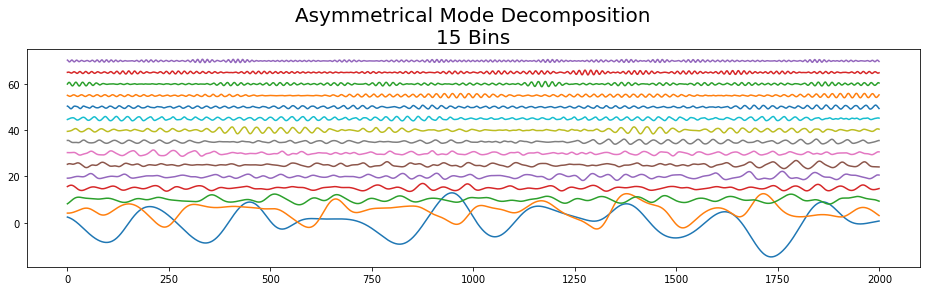

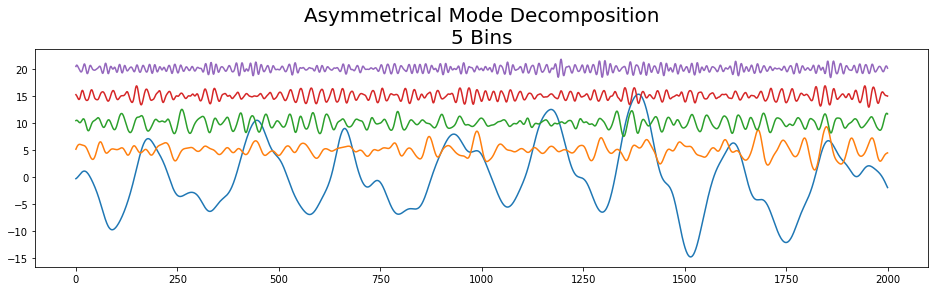

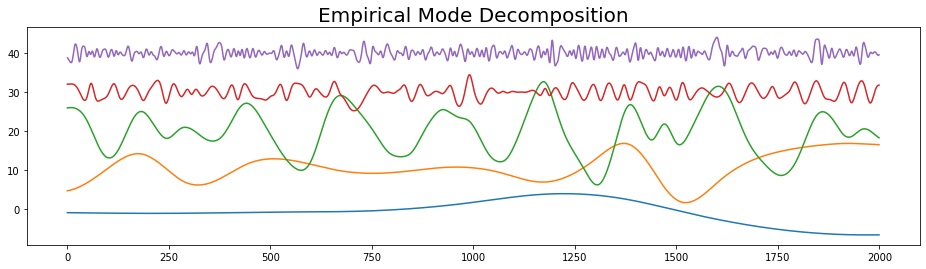

In [8]:
# Plot - 15 bins
_freqs = params['freqs']
sig_clust = np.zeros((15, len(_sig)))
_inds = np.linspace(0, len(_freqs), 16).astype(int)
l_inds, u_inds = _inds[:-1], _inds[1:]

for i, (l, u) in enumerate(zip(l_inds, u_inds)):
    sig_clust[i] = sig_osc_fit[l:u].sum(axis=0)
    
plt.figure(1, figsize=(16, 4))
plt.title('Asymmetrical Mode Decomposition\n15 Bins', size=20)
j = 0
for i in sig_clust:
    plt.plot(i+j)
    j += 5
    
# Plot - 5 bins
sig_clust = np.zeros((5, len(_sig)))
_inds = np.linspace(0, len(_freqs), 6).astype(int)
l_inds, u_inds = _inds[:-1], _inds[1:]

for i, (l, u) in enumerate(zip(l_inds, u_inds)):
    sig_clust[i] = sig_osc_fit[l:u].sum(axis=0)
    
plt.figure(0, figsize=(16, 4))
plt.title('Asymmetrical Mode Decomposition\n5 Bins', size=20)
j = 0
for i in sig_clust:
    plt.plot(i+j)
    j += 5
    
# EMD Comparison
plt.figure(2, figsize=(16, 4))
plt.title('Empirical Mode Decomposition', size=20)
j = 0
for i in x:
    plt.plot(i+j)
    j+=10

Once a signal is decomposed, the top variance modes may be combined to estimate the periodic component.

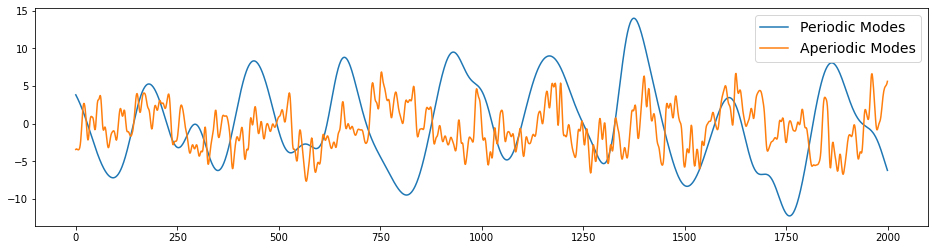

In [9]:
top = 10

inds_pe = np.argsort(sig_osc_fit.var(axis=1))[::-1][:top]
inds_ap = np.argsort(sig_osc_fit.var(axis=1))[::-1][top:]

sig_pe = sig_osc_fit[inds_pe].sum(axis=0)
sig_ap = sig_down - sig_pe 

plt.figure(0, figsize=(16, 4))
plt.plot(sig_pe, label='Periodic Modes')
plt.plot(sig_ap, label='Aperiodic Modes')
plt.legend(fontsize=14);